In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

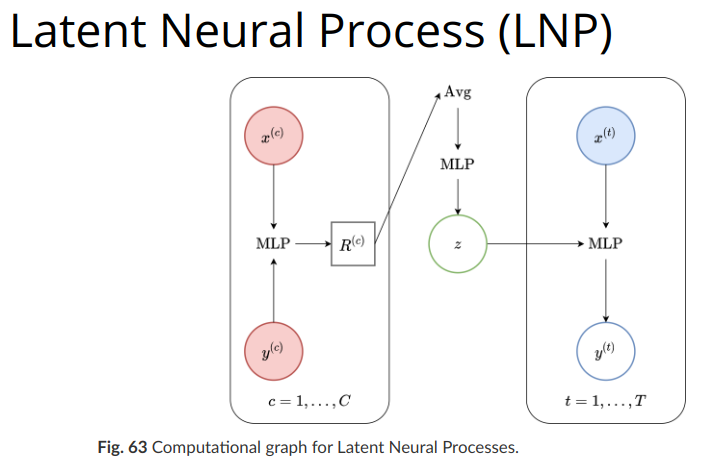

### Basic Idea of Neural Processes
Given a dataset with input-output pairs 
(x,y), a Neural Process learns a distribution over functions that can generalize to new data points.

It consists of an encoder, a latent distribution, and a decoder.

The model observes a context set (subset of points) and predicts values for a target set (new points).

**Unlike traditional neural networks, NPs output distributions instead of point estimates.**

In [50]:
# Encoder: Processes context points (x_c, y_c) into a latent representation
#          Output: Mean and standard deviation of the learned latent dist
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  # Mean of latent distribution
        self.fc_sigma = nn.Linear(hidden_dim, latent_dim)  # Std dev of latent distribution

    def forward(self, x, y):
        x, y = x.to(device), y.to(device)
        xy = torch.cat([x, y], dim=-1).to(device) # concatenates the input
        h = F.relu(self.fc1(xy))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        sigma = 0.1 + 0.9 * F.softplus(self.fc_sigma(h))  # Ensure positive std dev
        return mu, sigma

In [51]:
# Decoder: Takes sampled latent variables and predicts y-values for new x-values
class Decoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)  # Output predicted y

    def forward(self, x, z):
        x, z = x.to(device), z.to(device)
        
        # print(f"x shape: {x.shape}, z shape: {z.shape}")
        
        # Expand z to match the batch size of x
        # z is in the latent_dim
        # x is in the input_dim
        # Ensure `z` is broadcasted across `x`
        if z.dim() == 2:  # If `z` has shape [context_batch, latent_dim]
            z = z.mean(dim=0, keepdim=True)  # Aggregate across batch (mean pooling)
            z = z.expand(x.shape[0], -1)  # Broadcast to match x_target's batch size

        # print(f"x shape: {x.shape}, z shape: {z.shape}")
        
        xz = torch.cat([x, z], dim=-1).to(device)
        h = F.relu(self.fc1(xz))
        h = F.relu(self.fc2(h))
        return self.fc_out(h)

In [52]:
# Neural Process model
class NeuralProcess(nn.Module):
    def __init__(self, input_dim=1, latent_dim=16, hidden_dim=128):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(input_dim, latent_dim, hidden_dim)

    def forward(self, x_context, y_context, x_target):
        # Encode context points into latent distribution
        device = x_context.device
        x_context, y_context, x_target = x_context.to(device), y_context.to(device), x_target.to(device)
        mu, sigma = self.encoder(x_context, y_context)
        z = mu.mean(dim=0)  # Aggregate over context points (usually pooling is done)
        
        # Sample from latent distribution
        eps = torch.randn_like(sigma) # Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        z_sample = mu + sigma * eps  # Reparameterization trick

        y_pred = self.decoder(x_target, z_sample)
        return y_pred

In [53]:
def generate_sine_data(batch_size=16, num_points=50):
    x = torch.linspace(-3, 3, num_points).unsqueeze(-1)  # Shape: (num_points, 1)
    y = torch.sin(x) + 0.1 * torch.randn_like(x)  # noise
    return x, y

def train_neural_process(model, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    for epoch in range(epochs):
        x, y = generate_sine_data()
        
        # Randomly select context points
        idx = torch.randperm(x.shape[0])[:10]
        x_context, y_context = x[idx], y[idx]
        
        # Select all points as target
        x_target, y_target = x, y
        
        y_pred = model(x_context, y_context, x_target) # Forward pass
        
        loss = loss_fn(y_pred.to(device), y_target.to(device)) # Compute loss
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Train model
model = NeuralProcess().to(device)
train_neural_process(model)

Epoch 0, Loss: 0.5507752895355225


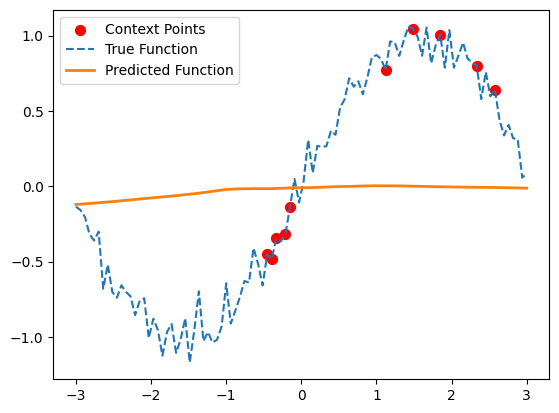

In [54]:
# Generate test points
x_test, y_test = generate_sine_data(num_points=100)

# Select random context points
idx = torch.randperm(x_test.shape[0])[:10]
x_context, y_context = x_test[idx], y_test[idx]

# Predict y-values
with torch.no_grad():
    y_pred = model(x_context, y_context, x_test)

# Plot results
plt.scatter(x_context.numpy(), y_context.numpy(), label="Context Points", color="red", s=50)
plt.plot(x_test.numpy(), y_test.numpy(), label="True Function", linestyle="dashed")
plt.plot(x_test.numpy(), y_pred.cpu().numpy(), label="Predicted Function", linewidth=2)
plt.legend()
plt.show()

In [55]:
# Train model
model = NeuralProcess().to(device)
train_neural_process(model, epochs=2001)

Epoch 0, Loss: 0.5918011665344238
Epoch 100, Loss: 0.04963729903101921
Epoch 200, Loss: 0.017072707414627075
Epoch 300, Loss: 0.01283569261431694
Epoch 400, Loss: 0.012440009973943233
Epoch 500, Loss: 0.009350678883492947
Epoch 600, Loss: 0.011087877675890923
Epoch 700, Loss: 0.012254578992724419
Epoch 800, Loss: 0.015540012158453465
Epoch 900, Loss: 0.010978748090565205
Epoch 1000, Loss: 0.017798952758312225
Epoch 1100, Loss: 0.014007365331053734
Epoch 1200, Loss: 0.01731567457318306
Epoch 1300, Loss: 0.02006685733795166
Epoch 1400, Loss: 0.013799890875816345
Epoch 1500, Loss: 0.01136168371886015
Epoch 1600, Loss: 0.011475997045636177
Epoch 1700, Loss: 0.015545932576060295
Epoch 1800, Loss: 0.007689627353101969
Epoch 1900, Loss: 0.009639570489525795
Epoch 2000, Loss: 0.008506816811859608


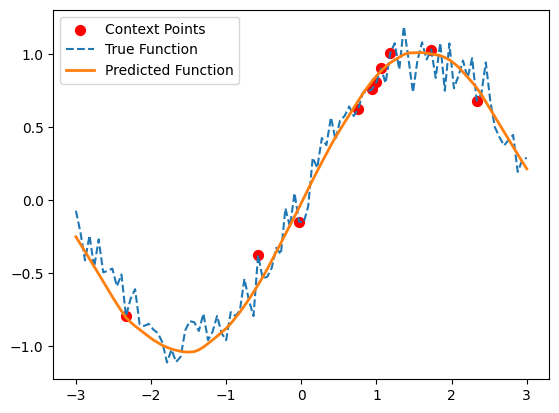

In [56]:
# Generate test points
x_test, y_test = generate_sine_data(num_points=100)

# Select random context points
idx = torch.randperm(x_test.shape[0])[:10]
x_context, y_context = x_test[idx], y_test[idx]

# Predict y-values
with torch.no_grad():
    y_pred = model(x_context, y_context, x_test)

# Plot results
plt.scatter(x_context.numpy(), y_context.numpy(), label="Context Points", color="red", s=50)
plt.plot(x_test.numpy(), y_test.numpy(), label="True Function", linestyle="dashed")
plt.plot(x_test.numpy(), y_pred.cpu().numpy(), label="Predicted Function", linewidth=2)
plt.legend()
plt.show()